#  Producing Fusion Spectra for the Neutron Generator

This note produces a spectrum of neutron enegries at the aftre either DT or TT fusion.

In order to calculate the neutron energy the following steps are taken:

1.) We sample the input velocities of the deuterons, or a triton for DT fusion from Maxwell-BOltzmann distirbutions, where the average energy is asusmed to be realte dto the applied HV of the neutron generator

2.) We sample a random angle to to determine the collision angle between the two particle.

3.) We sample a second random angle which is the emission angle of the neutron, and determine the nuetron energy from this angle sand simple scattering kinematics

4.) We transform the neutron energy back into the lab frame.

In [60]:
import numpy as np
import root_numpy as rn
import ROOT as ROOT
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from root_numpy import root2array, tree2array
import pandas as pd
from numpy.polynomial import legendre  
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (10.0, 7.0)

In [4]:
from IPython.core.display import HTML
HTML("<style>.container { wdith:90% !important;}</style>")
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code"></form>''')

In [108]:
##Lookup table of Legendre coefficients in COM frame for paramterization of differential cross-sections

##Deuterium-deuterium Fusion
A_d = [[0.025, 0.819, 0, 0.181, 0, 0], 
       [0.125, 0.785, 0, 0.215, 0, 0],
       [0.310, 0.758, 0, 0.241, 0, 0.001],
       [0.520, 0.737, 0, 0.261, 0, 0.002],
       [0.780, 0.719, 0, 0.279, 0, 0.002],
       [1.060, 0.705, 0, 0.292, 0, 0.003],
       [1.350, 0.692, 0, 0.304, 0, 0.004],
       [1.660, 0.681, 0, 0.314, 0, 0.005],
       [2.000, 0.671, 0, 0.323, 0, 0.006]]

##Deuterium-tritium Fusion
A_t = [[4.325, 1], 
       [19.6, 1],
       [52.9, 1],
       [106, 1],
       [175, 1],
       [250, 1],
       [315, 1],
       [367, 1],
       [394, 1]]


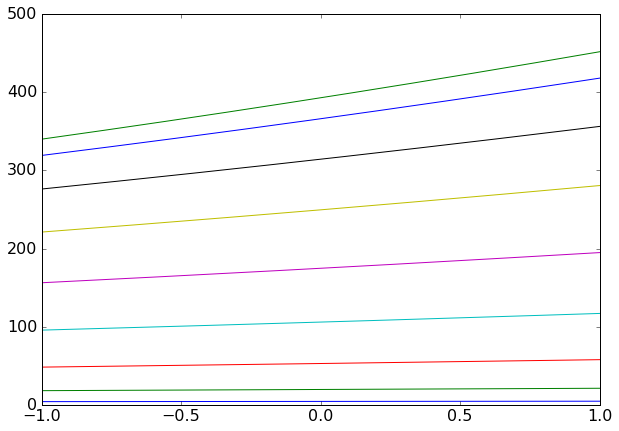

In [109]:
Energies=[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
fig = plt.figure(figsize=(10, 7))
particles=['deuteron', 'deuteron']
products=['helium3', 'neutron']
mass=[m_deuteron/1000, m_deuteron/1000]
product_mass=[m_helium3/1000, m_neutron/1000]
Q=3.269 #MeV
for index in range(len(A_d)):
    E_a=Energies[index]
    leg_coefficients = A_t[index][1:]
    cross_section = A_t[index][0]
    cos=np.linspace(-1, 1, 200)
    sin=np.sqrt(1-cos**2)
    beta_factor = np.sqrt(E_a*(E_a+2*mass[1]))/(mass[1]+mass[0]+E_a)
    gamma_factor = np.sqrt((mass[1]*product_mass[1]*E_a)/
                           (product_mass[0]*(product_mass[1]+product_mass[0])*Q+
                           product_mass[0]*(product_mass[1]+product_mass[0]-mass[1])*E_a))
    dtheta_dthetaprime = np.sqrt(1-gamma_factor**2*sin**2)/(gamma_factor*cos+np.sqrt(1-gamma_factor**2*sin**2))**2
    cos_prime = (beta_factor-cos)/(beta_factor*cos-1)   
    #Weighting factor using Liskien1982
    weight_prime = legendre.legval(cos_prime, leg_coefficients)*cross_section
    weight = weight_prime/dtheta_dthetaprime
    #weight_prime = legendre.legval(cos, leg_coefficients)*cross_section
    plt.plot(cos, weight)


In [137]:
##Produce Maxwell-Boltzmann Distribution with average energy equal to applied HV 
def gen_distribution(E_ave):
    prob_d=[]
    prob_t=[]
#E_ave=40 #keV
    m_neutron = 939576 #keV
    m_deuteron = 1875633 #keV
    m_triton=2808421 #keV
    m_helium3=2809388 #keV
    m_helium4=3728400 #keV
    num_div=10000
    max_v = 0.01
    v=np.linspace(0, max_v, num_div)
    kT_B = 2*E_ave/3
    MB_tv = (m_triton/(2*np.pi*kT_B))**(3/2)*4*np.pi*v**2*np.exp(-0.5*m_triton*v**2/kT_B)
    MB_dv = (m_deuteron/(2*np.pi*kT_B))**(3/2)*4*np.pi*v**2*np.exp(-0.5*m_deuteron*v**2/kT_B)
    prob_d=(MB_dv*(max_v/num_div))
    prob_t=(MB_tv*(max_v/num_div))
    prob_d = prob_d/np.sum(prob_d) 
    prob_t = prob_t/np.sum(prob_t)
    return (v, prob_d, prob_t)

In [166]:
##Produce Energy Histogram
def gen_spectrum(detector_pos, E_ave):
    #Generate velocity distributions
    velocity_dist=gen_distribution(E_ave)

    #particles=['deuteron', 'deuteron']
    #products=['helium3', 'neutron']
    #mass=[m_deuteron/1000, m_deuteron/1000]
    #product_mass=[m_helium3/1000, m_neutron/1000]
    tritium_abundance=0.0005
    emission_prob = []
    energies_lab=[]
    energies_boost=[]
    phi_angles=[]
    neutron_v=[]
    neutron_v_comps=[]
    for i in range(0, 1000000):
        particles=['deuteron', 'deuteron']
        products=['helium3', 'neutron']
        mass=[m_deuteron/1000, m_deuteron/1000]
        product_mass=[m_helium3/1000, m_neutron/1000]
    
        #Pick the particle energies from appropriate MB distirbutions
        velocities=np.random.choice(velocity_dist[0], 2, p=velocity_dist[1]) 
        Q=3.269 #MeV
        
        #Roll the dice for a DT fusion event
        p=np.random.ranf()
        if p<tritium_abundance:
            particles[0]='triton'
            mass[0]=m_triton/1000
            velocities[0]=np.random.choice(v, p=prob_t) 
            products[0]='helium4'
            product_mass[0]=m_helium4/1000
            Q=17.59 #MeV
    
        #Pick two random angles (in terms of cos(x) between -1 and 1:
        #0.) Collision angle in lab frame, to determine incident energy 
        #1.) Polar Emission angle of neutron in collision frame, to determine cross section and neutron energy
        #2.) Azimuthal Emission Angle in collision frame as transforming back to lab frame breaks symmetry
        angles=np.random.ranf(3)
 
        #Define co-ordinate systme such that particle[0] is moving along "x-axis" (x)
        #Determine incident particle energy in frame where particle[0] is stationary
        #All cross section data are beam on target, so to avoid mistakes we transform to 
        #co-ordinates where the triton/deuteron is stationary, and a deuteron is incident
        cos0=2*angles[0]-1
        sin0=np.sqrt(1-cos0**2)
        v01_x = velocities[1]*cos0#+velocities[0]
        v01_z = velocities[1]*sin0
        E_a=0.5*mass[1]*(v01_x**2+v01_z**2)  #Incident energy of deuteron in stationary frame   
    
        #From kinematics determine energy of emitted neutron using angle[1], where angle[1] is relative to
        #z-coordinate of collision (z')
        cos1 = 2*angles[1]-1
        cos1 = detector_pos*cos1 ######Stuff for Cylindrical check
        sin1 = np.sqrt(1-cos1**2)
        r_factor=np.sqrt(mass[1]*product_mass[1]*E_a)/(product_mass[1]+product_mass[0])*cos1
        s_factor=(E_a*(product_mass[0]-mass[1])+product_mass[0]*Q)/(product_mass[1]+product_mass[0])
        E_neutron = np.power(r_factor + np.sqrt(r_factor**2+s_factor),2)
    
        #Based on incident particle energy, determine appropriate coefficients from look-up table
        #A_x[i][0] is the cross section, A-x[i][1:] is the coefficients
        if particles[0]=='deuteron':
            leg_coefficients = A_d[np.clip(np.rint(E_a/0.010).astype(int)-2, 0, 8)][1:]
            cross_section = A_d[np.clip(np.rint(E_a/0.010).astype(int)-2, 0, 8)][0]
        elif particles[0]=='triton':
            leg_coefficients = A_t[np.clip(np.rint(E_a/0.010).astype(int)-2, 0, 8)][1:]
            cross_section = A_t[np.clip(np.rint(E_a/0.010).astype(int)-2, 0, 8)][0]
    
        #Determine relative cross section (compared to 90degrees) 
        #Cross section parametrization in center-of-mass frame
        #Some factors for converting between center-of-mass frame, and stationary target frame
        beta_factor = np.sqrt(E_a*(E_a+2*mass[1]))/(mass[1]+mass[0]+E_a)
        gamma_factor = np.sqrt((mass[1]*product_mass[1]*E_a)/
                           (product_mass[0]*(product_mass[1]+product_mass[0])*Q+
                           product_mass[0]*(product_mass[1]+product_mass[0]-mass[1])*E_a))
        dtheta_dthetaprime = np.sqrt(1-gamma_factor**2*sin1**2)/(gamma_factor*cos1+np.sqrt(1-gamma_factor**2*sin1**2))**2
        cos1_prime = (beta_factor-cos1)/(beta_factor*cos1-1)   
        #Weighting factor using Liskien1982
        weight_prime = legendre.legval(cos1_prime, leg_coefficients)*cross_section
        weight = weight_prime/dtheta_dthetaprime
        
        #Convert emitted neutron energy back into lab frame
        #Theta_neutron is neutron emission angle relative to velocity[0] 
        theta0_prime=np.arctan(v01_z/v01_x)
        theta1=np.arccos(cos1)
        theta_neutron=np.pi-theta0_prime-theta1
    
        #Determine rotation matrix to transform from collision x'-z' co-ordinates, to lab x-z co-ordinates
        theta_rot = 0.5*(theta0_prime-theta_neutron-theta1)
        c, s = np.cos(-theta_rot), np.sin(-theta_rot)
        R = np.matrix([[c, -s], [s, c]])
    
        #Determine z'-x' components of neutron energy (y' and y chosen to be common)
        #This is a polar angle so it can ranmge from 0 to 2pi
        phi2 = 2*np.pi*angles[2]
        cos2 = np.cos(phi2)
        sin2 = np.sin(phi2)
        v_neutron_prime = np.sqrt(2*E_neutron/product_mass[1])
        v_neutron_xprime = v_neutron_prime*sin1*cos2
        v_neutron_zprime = v_neutron_prime*cos1
        v_neutron_y = v_neutron_prime*sin1*sin2
        v_vector_prime = [v_neutron_zprime, v_neutron_xprime]
    
        #Transfrom to unprime (lab) co-ordinates and boost
        v_vector = np.dot(R, v_vector_prime)
        v_neutron_x = v_vector.item(1)+velocities[0]
        v_neutron_z = v_vector.item(0)
        v_neutron_lab2 = v_neutron_x**2+v_neutron_y**2+v_neutron_z**2
        E_neutron_boost = 0.5*product_mass[1]*v_neutron_lab2    
       
   
        theta0_prime=np.arctan(v01_z/v01_x)
        theta1=np.arccos(cos1)
        theta_neutron=np.pi-theta0_prime-theta1
        v_neutron = np.sqrt(2*E_neutron/product_mass[1])
        v_neutron_labx = v_neutron*np.cos(theta_neutron)#+velocities[0]
        v_neutron_lab2 = v_neutron_labx**2+(v_neutron*np.sin(theta_neutron))**2
        E_neutron_lab = 0.5*product_mass[1]*v_neutron_lab2   
    
        energies_lab.append(E_neutron_lab)
        emission_prob.append(weight)
        energies_boost.append(E_neutron_boost)
   
    return (energies_lab, emission_prob)


In [146]:
def plot_spectra(emission_prob, energies_lab):
    numrows=2
    numcols=2
    binwidth=0.01
    norm=[emission_prob[i]*binwidth for i in range(0, len(energies_lab))]
    norm_factor=np.sum(norm)
    fig = plt.figure(figsize=(15,10*numrows))
    fig.suptitle("Figure 1: Energy spectrum of neutrons produced from DD-fusion of %s keV deuterons" %E_ave, size=15)
    gridspec.GridSpec(numrows, numcols)
    
    plt.subplot2grid((numrows,numcols), (0,0), colspan=2)
    plt.hist(energies_lab, bins= 1400, normed=True, weights=emission_prob)
    ax0 = plt.gca()
    ax0.set_ylabel("Probability")
    ax0.set_xlabel("Energy [MeV]")

    plt.subplot2grid((numrows,numcols), (1,0))
    (n_dd, bins_dd, pathces_dd) = plt.hist(energies_lab, bins= 200, normed=True, range=[1.5, 3.5], weights=emission_prob)
    ax1 = plt.gca()
    ax1.set_ylabel("Probability")
    ax1.set_xlabel("Energy [MeV]")

    plt.subplot2grid((numrows,numcols), (1,1))
    (n_dt, bins_dt, pathces_dt) = plt.hist(energies_lab, bins= 400, normed=True, range=[12,16], weights=emission_prob)
    ax2.set_ylabel("Probability")
    ax2.set_xlabel("Energy [MeV]")

    return (plt.show())

In [161]:
def plot_dd_spectra(emission_prob, energies_lab, colour, angle):
    numrows=1
    numcols=1
    binwidth=0.01
    norm=[emission_prob[i]*binwidth for i in range(0, len(energies_lab))]
    norm_factor=np.sum(norm)
    fig = plt.figure(figsize=(7, 5*numrows))
    fig.suptitle("Figure 1: Energy spectrum of neutrons at %s polar angle (%s keV)" %(angle, E_ave) , size=15)
    gridspec.GridSpec(numrows, numcols)
    
    plt.subplot2grid((numrows,numcols), (0,0))
    (n_dd, bins_dd, pathces_dd) = plt.hist(energies_lab, bins= 200, normed=True, range=[1.5, 3.5], color=colour, weights=emission_prob)
    ax0 = plt.gca()
    ax0.set_ylabel("Probability")
    ax0.set_xlabel("Energy [MeV]")

    return (plt, n_dd)

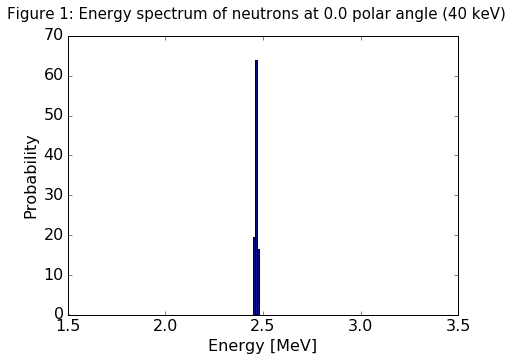

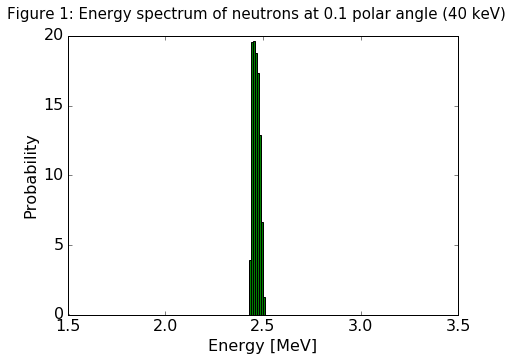

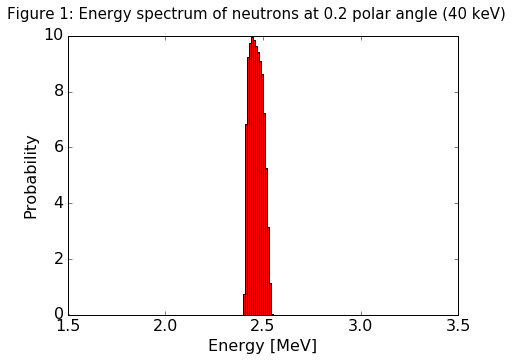

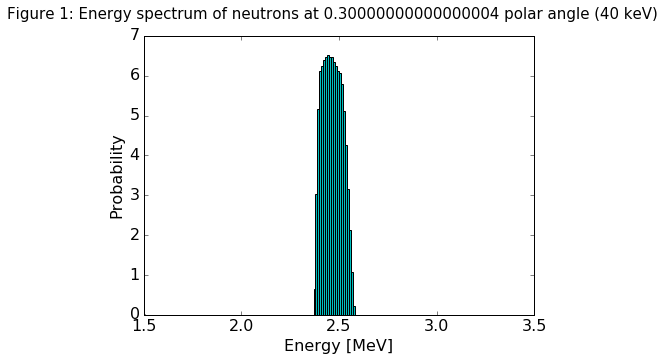

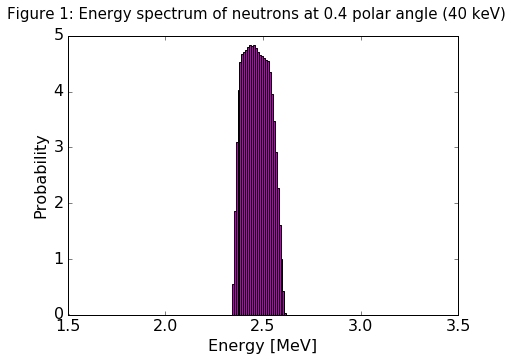

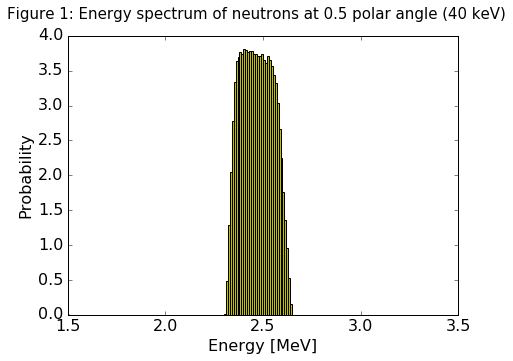

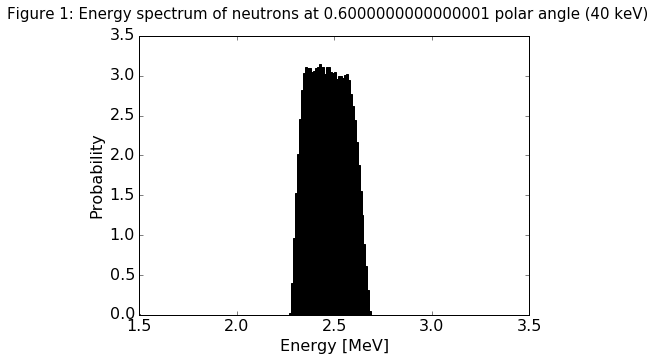

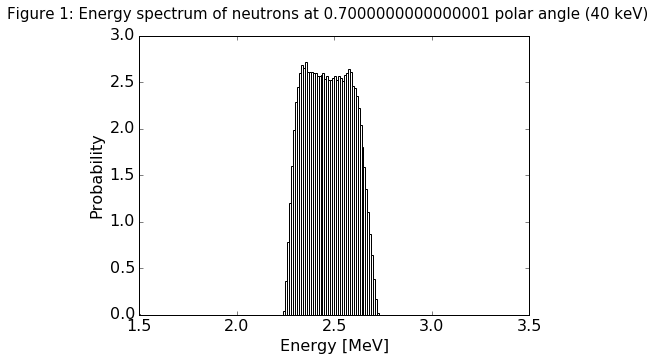

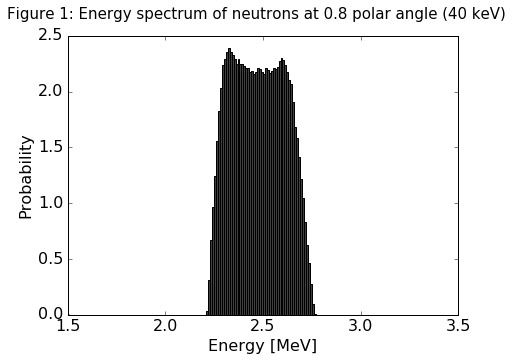

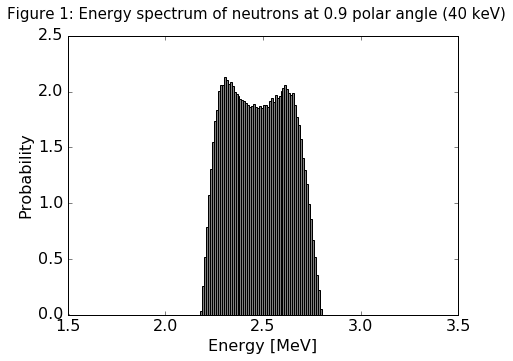

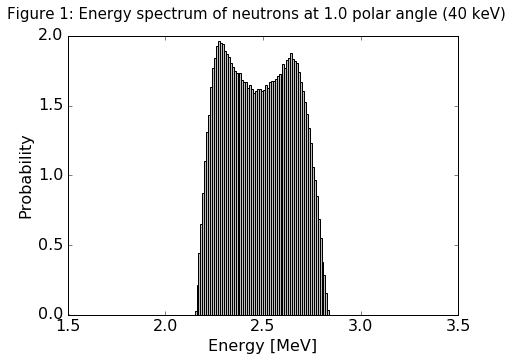

In [167]:
colours=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '0.25', '0.5', '0.75']
for pos in range(0, 11):
    output=gen_spectrum(0.1*pos, 40)
    plot_output = plot_dd_spectra(output[1], output[0], colours[pos], 0.1*pos)
    plot_output[0].show()

In [104]:
f=open('dd_fusion_%dkeV.dat' %E_ave, 'w')
#print (f)
f.write('unit: MeV\n')
f.write('spectrum:\n')
for entry in range(len(bins_dd)-1):
    f.write('%f %f\n' %(bins_dd[entry], n_dd[entry]))
f.write('%f 0' %bins_dd[len(bins_dd)-1])
f.close()


In [107]:
f2=open('dt_fusion_%dkeV.dat' %E_ave, 'w')
#print (f)
f2.write('unit: MeV\n')
f2.write('spectrum:\n')
for entry in range(len(bins_dt)-1):
    #print ('%f %f' %(bins_dt[entry], n_dt[entry]))
    f2.write('%f %f\n' %(bins_dt[entry], n_dt[entry]))
f2.write('%f 0' %bins_dt[len(bins_dt)-1])
f2.close()